In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import datetime
import pandas
import numpy
import matplotlib.pyplot as plt

## Start Spark Session 
spark = SparkSession \
    .builder \
    .appName("Wrangling Data NY Taxi") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/04 21:01:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Import packages
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/12/04 21:01:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "train.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True)
df.show()

24/12/04 21:02:14 WARN SparkContext: The path train.csv has been added already. Overwriting of added paths is not supported in the current version.


+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [6]:
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [8]:
import pandas as pd

p_df = pd.read_csv("train.csv")
p_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import seaborn as sns

In [14]:
# Load the dataset (CSV file should be downloaded first)
# Update this path to where the file is located
file_path = "train.csv"
data = pd.read_csv(file_path)
# Basic data inspection
print(data.info())
print(data.head())
# Drop rows with missing target variable (trip duration)
data.dropna(subset=['trip_duration'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394     

In [15]:
# Feature engineering
# Convert pickup datetime to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour_of_day'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

In [16]:
data['day_of_week'].unique()

array([0, 6, 1, 2, 5, 4, 3], dtype=int32)

In [17]:
# Add distance feature (Haversine formula for distance between pickup and dropoff)
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Earth radius in km (mean radius)
    return 6371 * c
data['distance'] = haversine(data['pickup_longitude'], data['pickup_latitude'],
                             data['dropoff_longitude'], data['dropoff_latitude'])

In [18]:
# Selecting relevant features for the model
features = ['hour_of_day', 'day_of_week', 'passenger_count', 'distance']
X = data[features]
y = data['trip_duration']  # Target variable: trip duration
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Predict on test data
y_pred = model.predict(X_test)

In [21]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 498.7778151183648


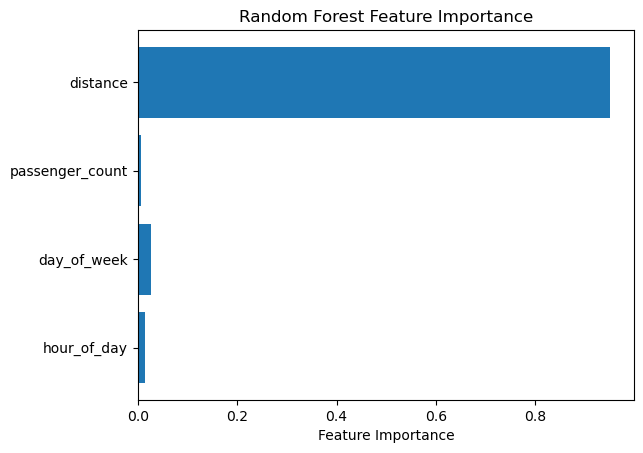

In [22]:
# Feature importance visualization
feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

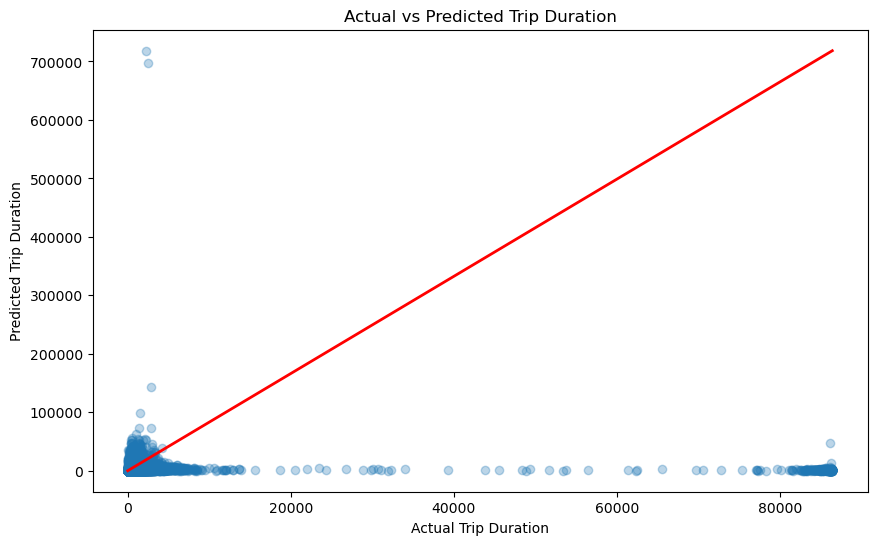

In [23]:
# Prediction vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', linewidth=2)
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.show()